# Project-4: Классификация потенциальных клиентов банка на предмет открытия депозита

### Business case:
Необходимо определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.
### Техническое задание:
Построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.
### Основные цели проекта:
1. Исследовать данные.
2. Попробовать выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка.
3. Использовать разные инструменты для повышения качества прогноза.

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:

1. age (возраст);
2. job (сфера занятости);
3. marital (семейное положение);
4. education (уровень образования);
5. default (имеется ли просроченный кредит);
6. housing (имеется ли кредит на жильё);
7. loan (имеется ли кредит на личные нужды);
8. balance (баланс).
Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

9. contact (тип контакта с клиентом);
10. month (месяц, в котором был последний контакт);
11. day (день, в который был последний контакт);
12. duration (продолжительность контакта в секундах).
Прочие признаки:

13. campaign (количество контактов с этим клиентом в течение текущей кампании);
14. pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
15. previous (количество контактов до текущей кампании)
16. poutcome (результат прошлой маркетинговой кампании).
17. целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

#### Знакомимся с данными и проверяем наличие пропусков

In [171]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [172]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [173]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [175]:
df.isnull().sum()


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Проверяем, нет ли пропусков, обозначенных иначе в данных типа object

In [176]:
columns_to_check = ['job','marital','education','default','housing','loan','contact','month','poutcome','deposit']
unique_items ={}
for column in columns_to_check:
    unique_items[column] = df[column].unique()

In [177]:
unique_items

{'job': array(['admin.', 'technician', 'services', 'management', 'retired',
        'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
        'unknown', 'self-employed', 'student'], dtype=object),
 'marital': array(['married', 'single', 'divorced'], dtype=object),
 'education': array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object),
 'default': array(['no', 'yes'], dtype=object),
 'housing': array(['yes', 'no'], dtype=object),
 'loan': array(['no', 'yes'], dtype=object),
 'contact': array(['unknown', 'cellular', 'telephone'], dtype=object),
 'month': array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
        'mar', 'apr', 'sep'], dtype=object),
 'poutcome': array(['unknown', 'other', 'failure', 'success'], dtype=object),
 'deposit': array(['yes', 'no'], dtype=object)}

Видим, что есть пропуски в признаках job, education, contact, poutcome. Они обозначенны словом unknown.

#### Преобразуем признак balance из типа данных object во float, так как он логично должен быть числовым:

In [178]:
df['balance'] = df['balance'].replace({'\$': '', ',': '.',' ':''}, regex=True).astype(float)

#### Обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку:

In [179]:
df['balance'] = df['balance'].fillna(df['balance'].median())

#### Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения:

In [180]:
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)
print(df['job'].unique())
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)
print(df['education'].unique())

['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'self-employed' 'student']
['secondary' 'tertiary' 'primary']


In [181]:
#проверим себя:
job_mode = df['job'].mode()[0]
edu_mode = df['education'].mode()[0]
mb = df[(df['job']==job_mode)&(df['education']==edu_mode)]['balance'].mean()
print(round(mb,3))

1598.883


#### Посмотрим на распределение признака balance:

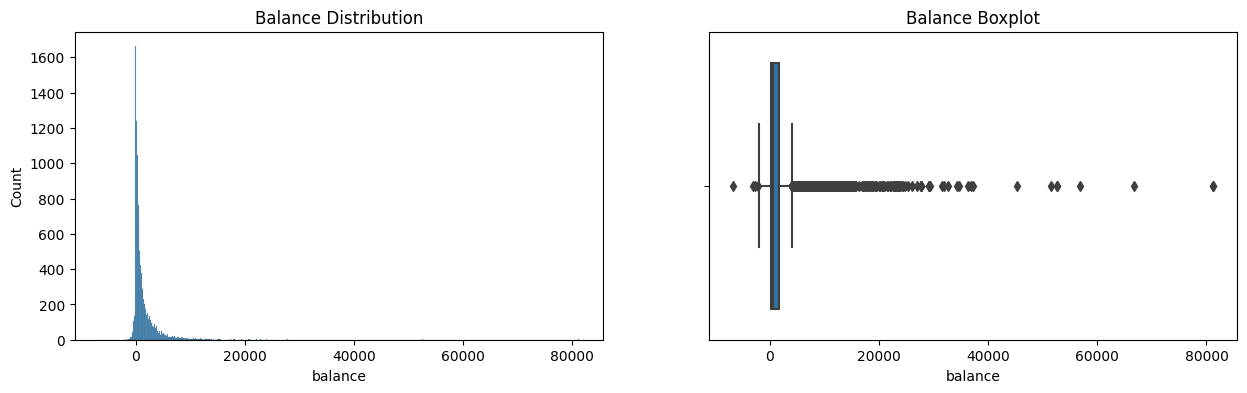

In [182]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Balance Boxplot');

Мы видим, что есть выбросы. Удалим их с помощью метода Тьюки:

In [183]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')


Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


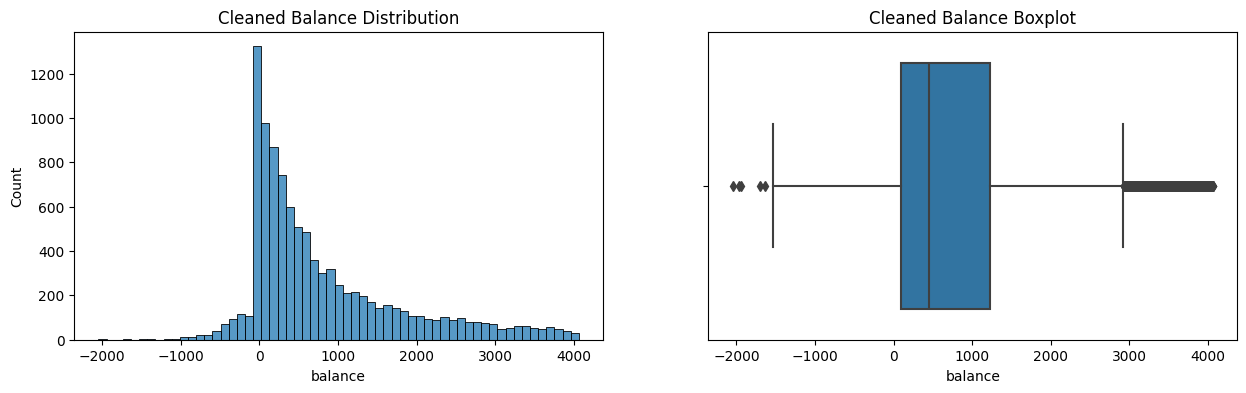

In [184]:
#проверим результат:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Balance Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Balance Boxplot');

In [185]:
df = cleaned

#### Посмотрим на распределение признака duration:

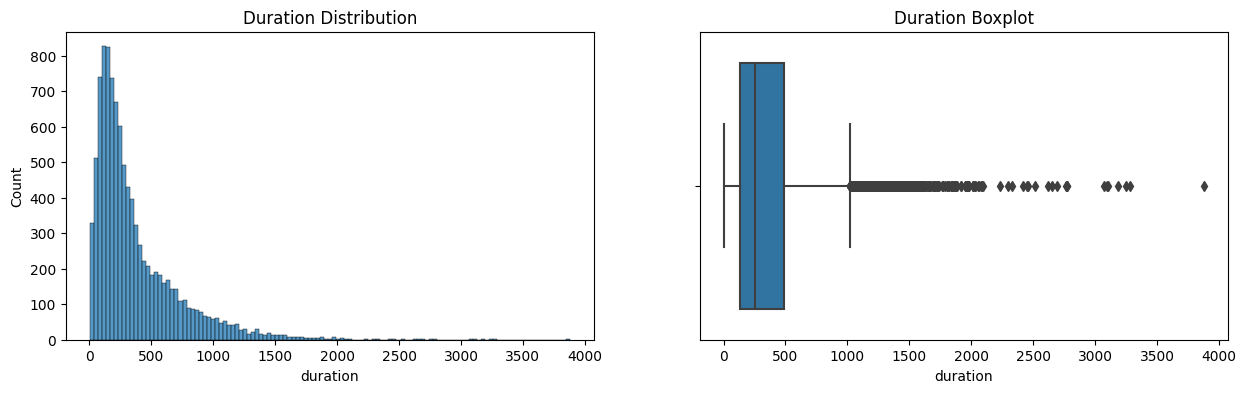

In [187]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='duration', ax=axes[0]);
histplot.set_title('Duration Distribution');
boxplot = sns.boxplot(data=df, x='duration', ax=axes[1]);
boxplot.set_title('Duration Boxplot');

In [188]:
outliers, cleaned = outliers_iqr(df, 'duration')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 591
Результирующее число записей: 9514


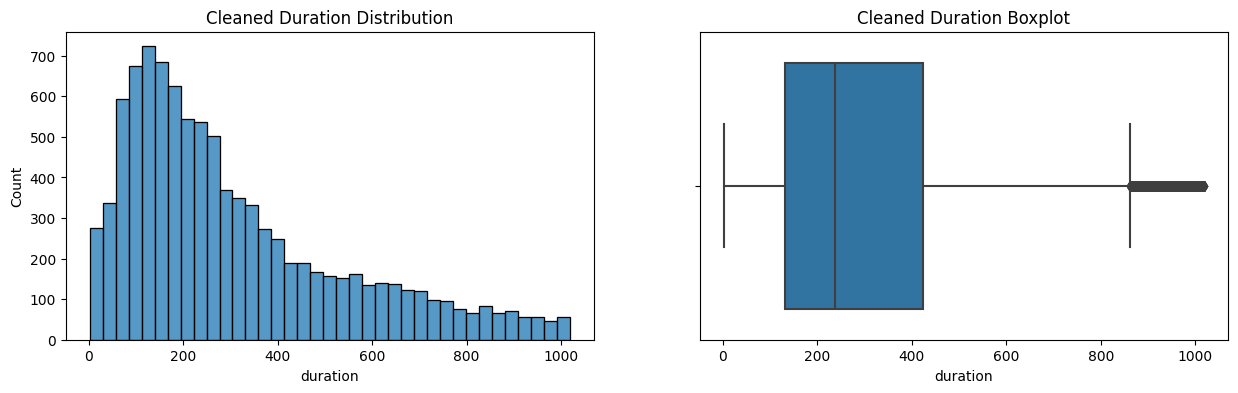

In [190]:
#проверим результат:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='duration', ax=axes[0]);
histplot.set_title('Cleaned Duration Distribution');
boxplot = sns.boxplot(data=cleaned, x='duration', ax=axes[1]);
boxplot.set_title('Cleaned Duration Boxplot');

## Часть 2:  Разведывательный анализ

#### Изучим соотношение классов в ваших данных на предмет несбалансированности:

<Axes: xlabel='deposit', ylabel='count'>

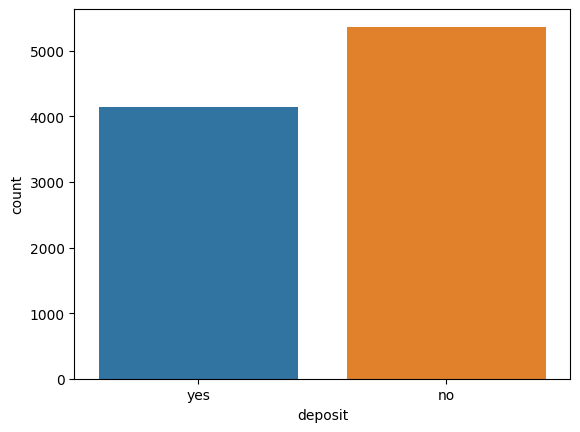

In [191]:
df = cleaned
df['deposit'].value_counts()
sns.countplot(data=df, x='deposit')

Классы вполне сбалансированы.

#### Рассчитаем описательные статистики для количественных переменных:

In [192]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000,9514.000000
mean,40.928211,805.229136,15.602796,307.402354,2.504099,52.497898,0.838869
std,11.803304,994.598902,8.467498,233.822852,2.725971,110.545355,2.254164
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,94.000000,8.000000,131.000000,1.000000,-1.000000,0.000000
50%,38.000000,440.000000,15.000000,237.000000,2.000000,-1.000000,0.000000
75%,49.000000,1220.750000,22.000000,423.000000,3.000000,50.000000,1.000000
max,95.000000,4063.000000,31.000000,1019.000000,43.000000,854.000000,58.000000


#### Рассчитаем описательные статистики для категориальных переменных:

In [193]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,9514,9514,9514,9514,9514,9514,9514,9514,9514,9514
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2191,5404,5189,9352,4995,8222,6880,2466,7061,5368


Посмотрим на графиках процентные доли значений категориальных переменных, а также соотношение удачи и неудачи текущей маркетинговой кампании в зависимости от каждой категорииальной переменной:

In [194]:
#получим список категориальных переменных всех, кроме целевой, для визуализации:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features.pop()
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

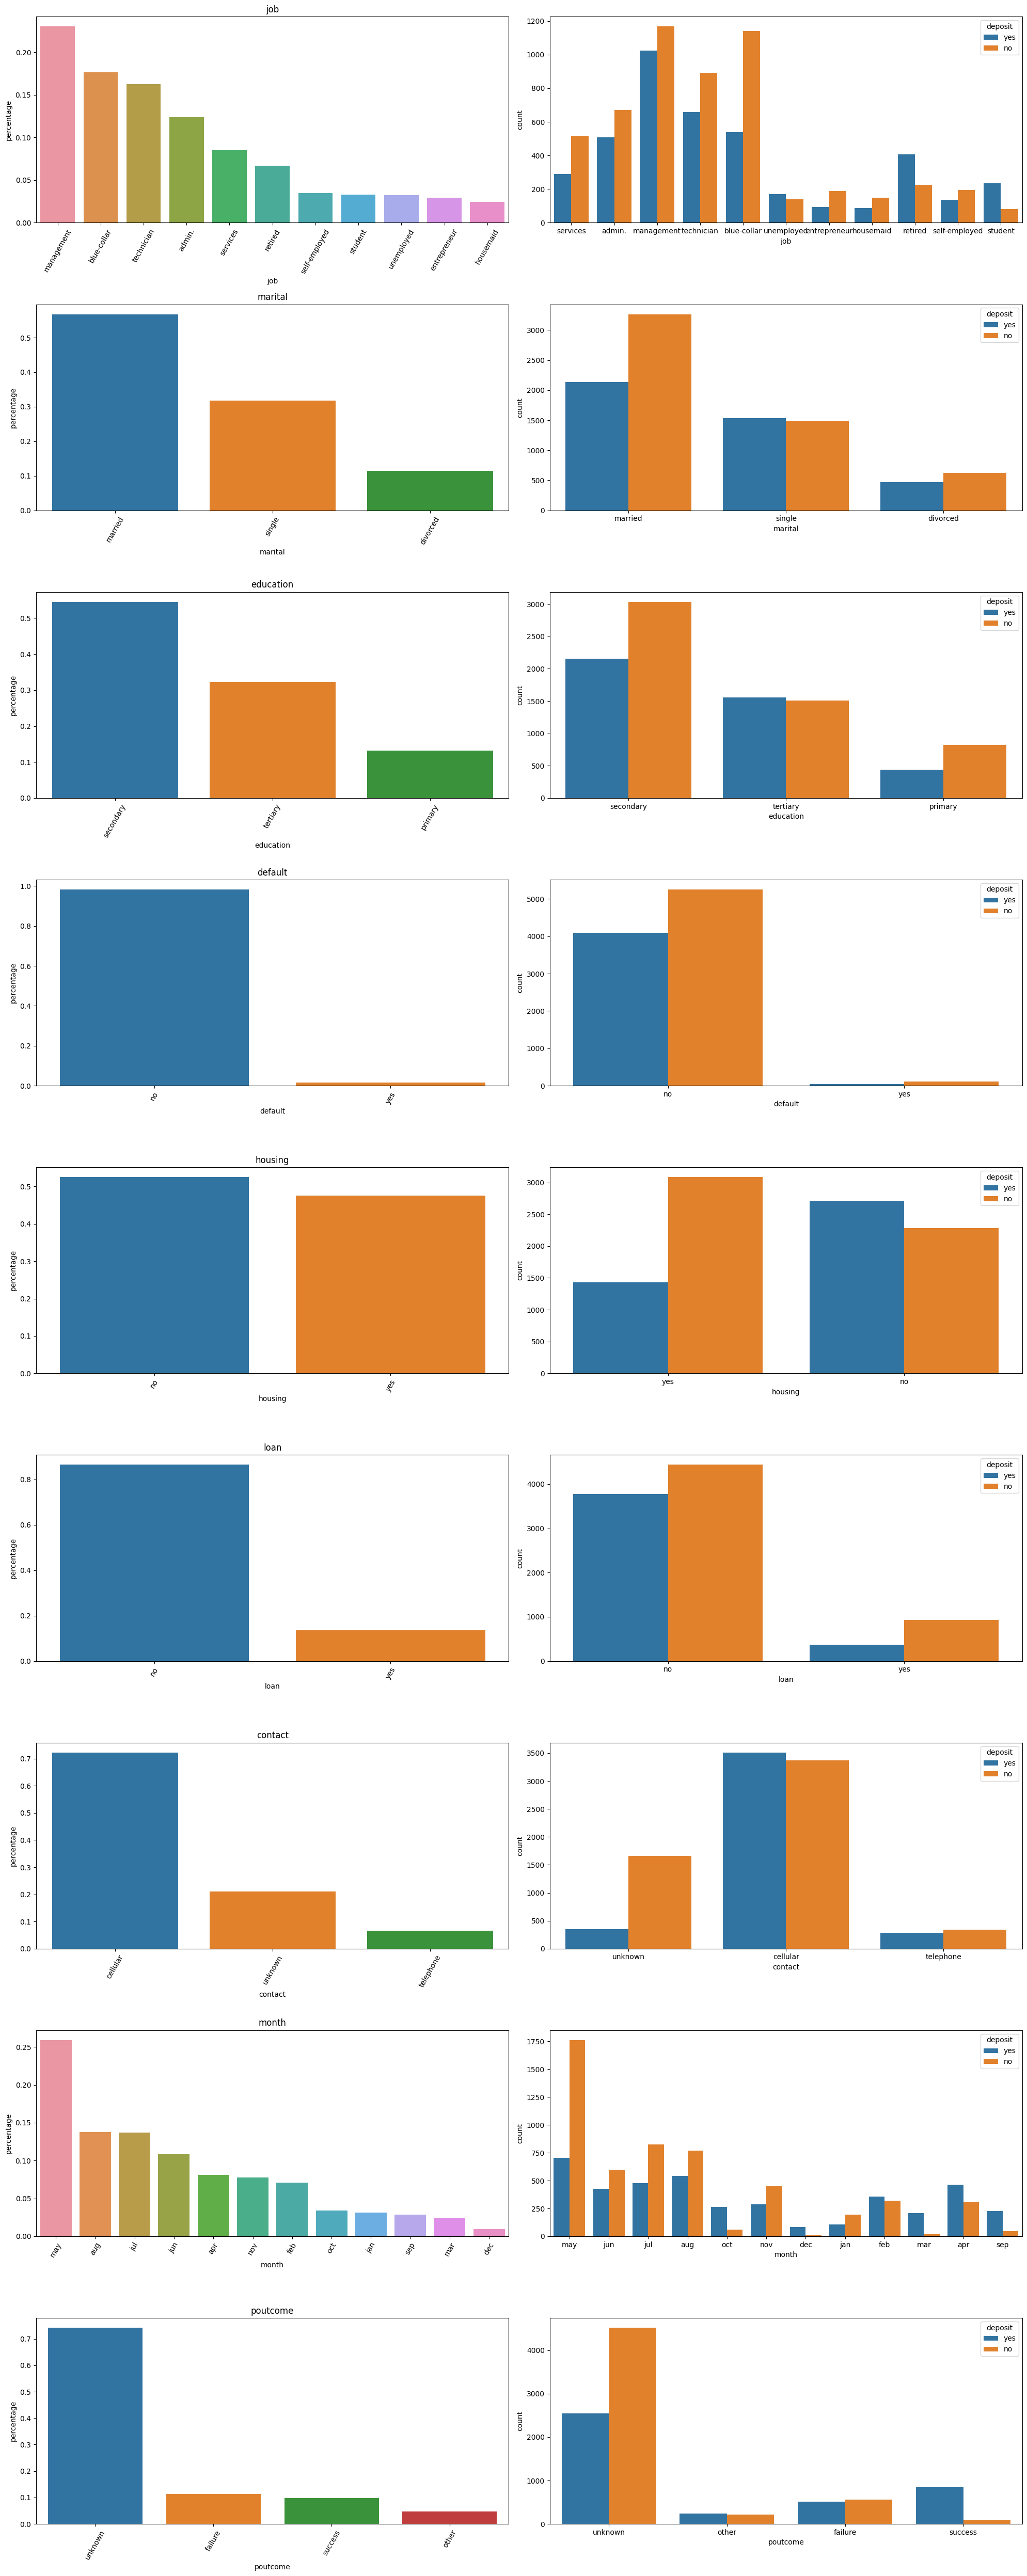

In [195]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(20, 50))#фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x = feature, y='percentage',ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    count_barplot.set_title(feature)
    #Строим столбчатую диаграмму количества людей, сделавших депозит в зависимости от категории
    countplot = sns.countplot(data=df, x=feature, hue = 'deposit', ax=axes[i][1])
    #countplot.set_title(feature)
plt.tight_layout() #выравнивание графиков

In [196]:
#выберем значение признака poutcome, при котором кол-во успешных случаев текущей маркетинговой кампании превалирует над неуспешными
grouped = df.groupby('poutcome')['deposit'].value_counts().unstack()
grouped['dif'] = grouped['yes']-grouped['no']
grouped['dif'].nlargest(1)

poutcome
success    757
Name: dif, dtype: int64

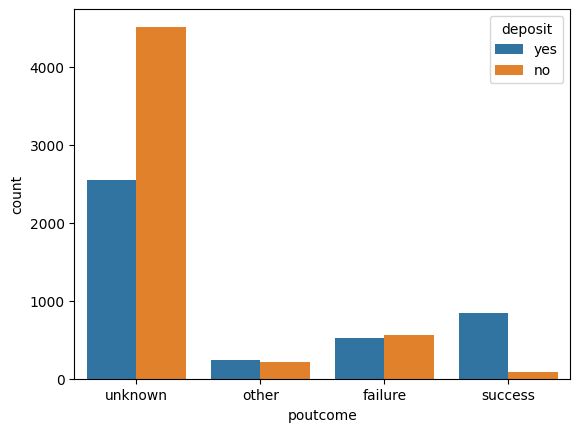

In [197]:
#визуализируем результат:
countplot = sns.countplot(data=df, x='poutcome', hue = 'deposit')

Судя по графику выше, те, с кем сработала предыдущая маркетинговая кампания, охотно соглашаются открыть депозит в текущую.

Посмотрим пристальнее на график разбивки по месяцам:

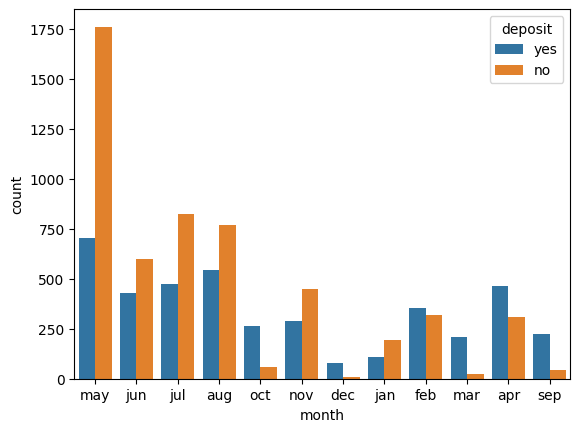

In [198]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
countplot = sns.countplot(data=df, x='month', hue = 'deposit')

Очевидно, что май - не лучшее время для проведения маркетинговой кампании (отказы сильно превалируют над согласием открыть депозит), хотя именно в мае и был ее пик. Видно, что успешными были октябрь, март, апрель и сентябрь.

In [199]:
grouped = df.groupby('month')['deposit'].value_counts().unstack()
grouped['dif'] = grouped['no']-grouped['yes']
grouped['dif'].nlargest(1)

month
may    1058
Name: dif, dtype: int64

Признак age, хоть и числовой, но он определенно категориальный, разделим его на возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения:

In [200]:
def age_group(x):
    if x < 30:
      return 1
    elif 30 <= x < 40:
      return 2
    elif 40 <= x < 50:
      return 3
    elif 50 <= x < 60:
      return 4
    elif x >= 60:
      return 5

df['age_group'] = df['age'].apply(age_group)

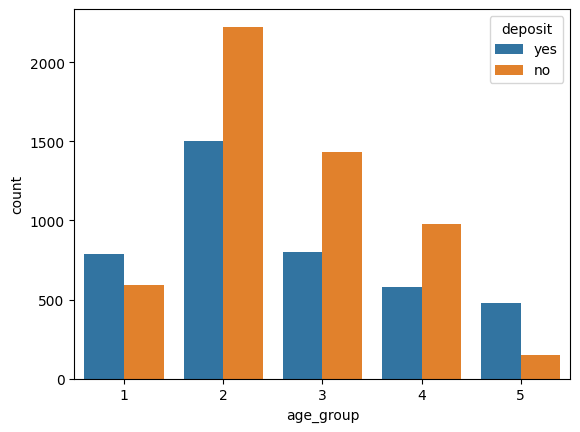

In [201]:
countplot = sns.countplot(data=df, x='age_group', hue = 'deposit')

Мы видим, что более склонны оформлять депозит либо люди младше 30 лет, либо уже старше 60. По диаграмме с сферами деятельности выше видно также, что кампания более успешна у студентов и пенсионеров.

Посмотрим теперь на то, как влияют пересечения двух категорий marital и education на принятие решения об открытии депозита:

In [202]:
#разделим данные на две части - согласившиеся и несогласившиеся
df_no = df[df['deposit'] == 'no']
df_yes = df[df['deposit'] == 'yes'] 

# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
group_no = df_no.groupby('marital')['education'].value_counts().unstack()
group_no

education,primary,secondary,tertiary
marital,,,
divorced,91,369,161
married,631,1810,824
single,99,857,526


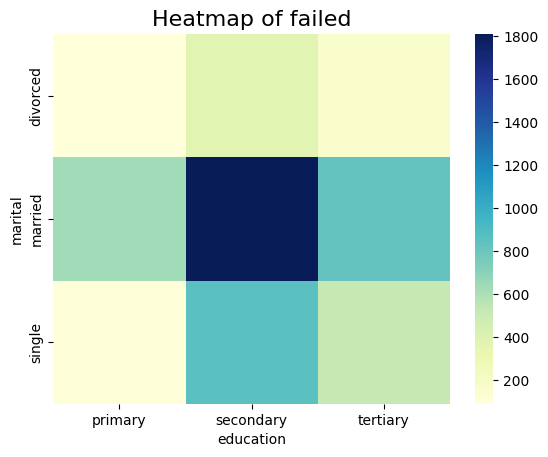

In [203]:
#визуализируем результат для отказавшихся от депозита
heatmap = sns.heatmap(data=group_no, cmap='YlGnBu')
heatmap.set_title('Heatmap of failed', fontsize=16);

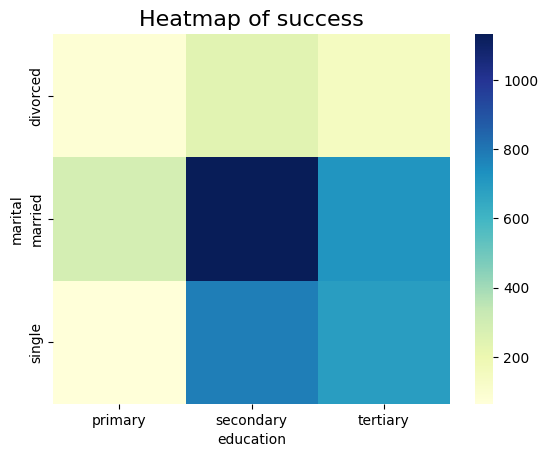

In [204]:
#визуализируем результат для согласившихся открыть депозит
group_yes = df_yes.groupby('marital')['education'].value_counts().unstack()
group_yes
heatmap = sns.heatmap(data=group_yes, cmap='YlGnBu')
heatmap.set_title('Heatmap of success', fontsize=16);

Видим, что амая многочисленная группа и среди тех, кто открыл депозит, и среди тех, кто отказался  - одна и та же.

Попробуем посмотреть на числовые признаки:

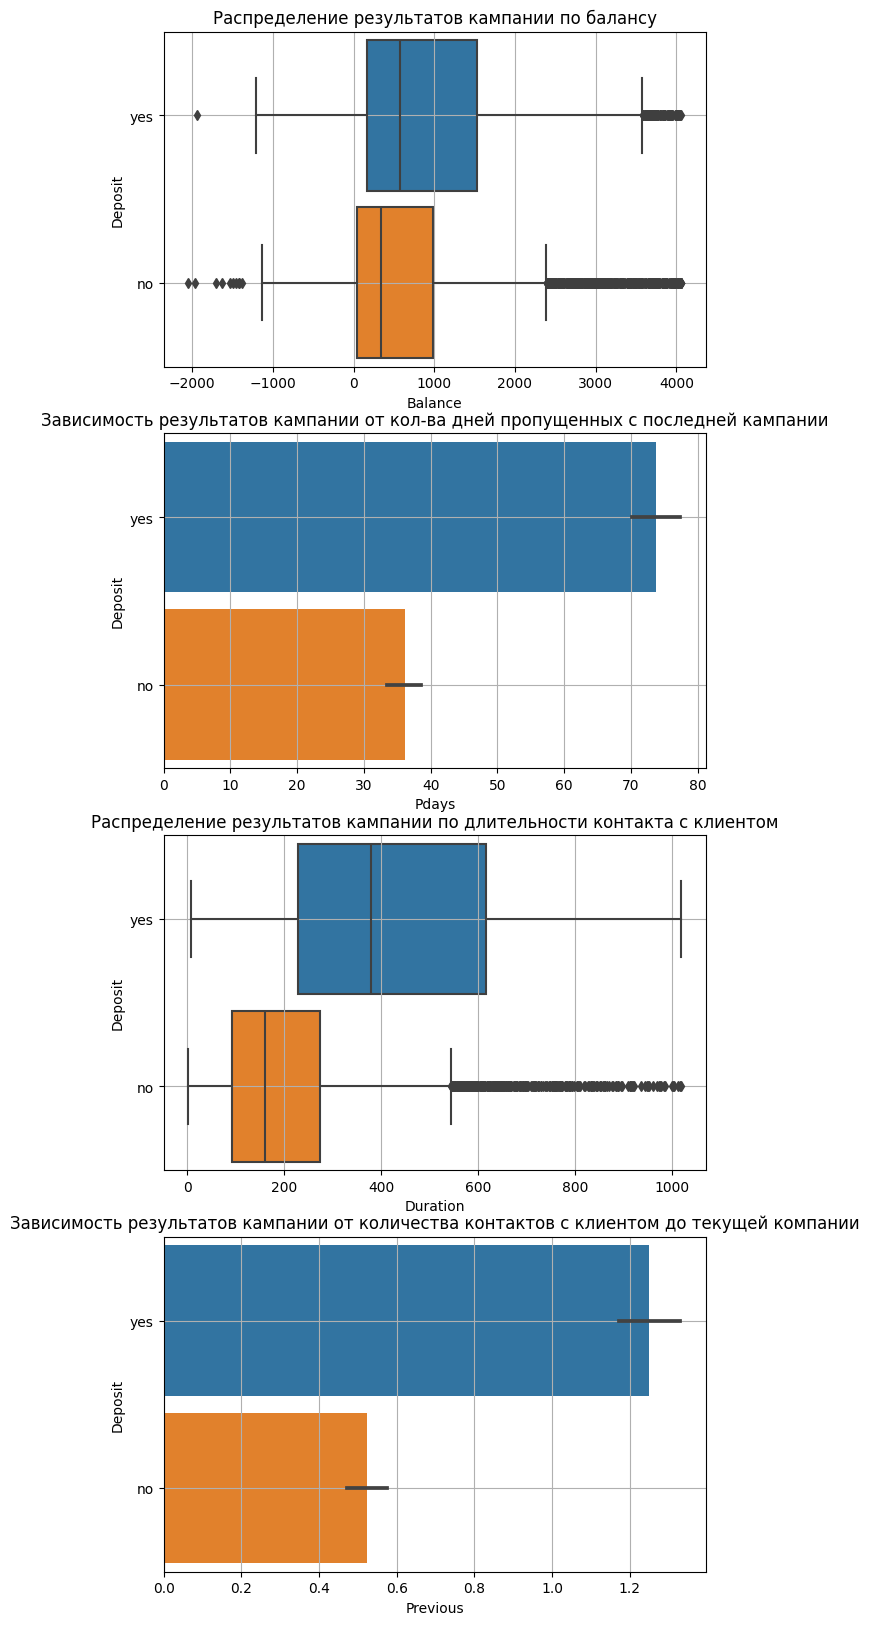

In [208]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 20))
boxplot = sns.boxplot(
    data=df,
    y='deposit',
    x='balance',
    orient='h',
    width=0.9,
    ax=axes[0]
)
boxplot.set_title('Распределение результатов кампании по балансу');
boxplot.set_xlabel('Balance');
boxplot.set_ylabel('Deposit');
boxplot.grid()

boxplot2 = sns.barplot(
    data=df,
    y='deposit',
    x='pdays',
    orient='h',
    width=0.9,
    ax=axes[1]
)
boxplot2.set_title('Зависимость результатов кампании от кол-ва дней пропущенных с последней кампании');
boxplot2.set_xlabel('Pdays');
boxplot2.set_ylabel('Deposit');
boxplot2.grid()

boxplot3 = sns.boxplot(
    data=df,
    y='deposit',
    x='duration',
    orient='h',
    width=0.9,
    ax=axes[2]
)
boxplot3.set_title('Распределение результатов кампании по длительности контакта с клиентом');
boxplot3.set_xlabel('Duration');
boxplot3.set_ylabel('Deposit');
boxplot3.grid()

boxplot4 = sns.barplot(
    data=df,
    y='deposit',
    x='previous',
    orient='h',
    width=0.9,
    ax=axes[3]
)
boxplot4.set_title('Зависимость результатов кампании от количества контактов с клиентом до текущей компании');
boxplot4.set_xlabel('Previous');
boxplot4.set_ylabel('Deposit');
boxplot4.grid()

Из графиков выше видно, что от некоторых усилий сотрудников банка зависит успешность маркетинговой кампании - от количества контактов, их продолжительности. А также, очевидно,те клиенты, у которых больше денег на счету, охотнее соглашаются открыть депозит.

## Часть 3: преобразование данных

Закодируем признаки education и age_group с помощью LabelEncoder:

In [209]:
l_encoder = LabelEncoder()
encoded = l_encoder.fit_transform(df['education'])
df = df.drop(columns='education')
encoded = pd.DataFrame(encoded, index=df.index, columns=['education'])
df = pd.concat([df, encoded], axis=1)

In [210]:
l_encoder = LabelEncoder()
encoded = l_encoder.fit_transform(df['age_group'])
df = df.drop(columns='age_group')
encoded = pd.DataFrame(encoded, index=df.index, columns=['age_group'])
df = pd.concat([df, encoded], axis=1)

Преобразуем бинарные переменные в представление из нулей и единиц:

In [211]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
df['deposit'].std()
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
#sa = df['default'].mean()+df['housing'].mean()+df['loan'].mean()
#print(round(sa,3))

In [212]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9514 entries, 3 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        9514 non-null   int64  
 1   job        9514 non-null   object 
 2   marital    9514 non-null   object 
 3   default    9514 non-null   int64  
 4   balance    9514 non-null   float64
 5   housing    9514 non-null   int64  
 6   loan       9514 non-null   int64  
 7   contact    9514 non-null   object 
 8   day        9514 non-null   int64  
 9   month      9514 non-null   object 
 10  duration   9514 non-null   int64  
 11  campaign   9514 non-null   int64  
 12  pdays      9514 non-null   int64  
 13  previous   9514 non-null   int64  
 14  poutcome   9514 non-null   object 
 15  deposit    9514 non-null   int64  
 16  education  9514 non-null   int32  
 17  age_group  9514 non-null   int64  
dtypes: float64(1), int32(1), int64(11), object(5)
memory usage: 1.3+ MB


Закодируем текстовые категориальные признаки с помощью get_dummies:

In [213]:
# создаем дамми-переменные
dummies_data = pd.get_dummies(df[['job','marital','contact','month','poutcome']])
df = pd.concat([df, dummies_data], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9514 entries, 3 to 11161
Data columns (total 51 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                9514 non-null   int64  
 1   job                9514 non-null   object 
 2   marital            9514 non-null   object 
 3   default            9514 non-null   int64  
 4   balance            9514 non-null   float64
 5   housing            9514 non-null   int64  
 6   loan               9514 non-null   int64  
 7   contact            9514 non-null   object 
 8   day                9514 non-null   int64  
 9   month              9514 non-null   object 
 10  duration           9514 non-null   int64  
 11  campaign           9514 non-null   int64  
 12  pdays              9514 non-null   int64  
 13  previous           9514 non-null   int64  
 14  poutcome           9514 non-null   object 
 15  deposit            9514 non-null   int64  
 16  education          9514 non-

In [214]:
df = df.drop(['job','marital','contact','month','poutcome'], axis=1) #избавимся от уже перекодированных столбцов

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9514 entries, 3 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                9514 non-null   int64  
 1   default            9514 non-null   int64  
 2   balance            9514 non-null   float64
 3   housing            9514 non-null   int64  
 4   loan               9514 non-null   int64  
 5   day                9514 non-null   int64  
 6   duration           9514 non-null   int64  
 7   campaign           9514 non-null   int64  
 8   pdays              9514 non-null   int64  
 9   previous           9514 non-null   int64  
 10  deposit            9514 non-null   int64  
 11  education          9514 non-null   int32  
 12  age_group          9514 non-null   int64  
 13  job_admin.         9514 non-null   bool   
 14  job_blue-collar    9514 non-null   bool   
 15  job_entrepreneur   9514 non-null   bool   
 16  job_housemaid      9514 non-

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности:

In [216]:
#fig, axes = plt.subplots(figsize=(40, 50))
#sns.heatmap(df.corr(), annot = True)
to_viz = df.corr()['deposit'].sort_values(ascending=False) #построим таблицу корреляций по отношению к целевому признаку

In [217]:
#визуализируем таблицу корреляций
import plotly.express as px
display(to_viz)
fig = px.bar(to_viz)
fig.show()

deposit              1.000000
duration             0.475882
poutcome_success     0.313525
contact_cellular     0.243427
pdays                0.168798
previous             0.159686
month_mar            0.147376
month_oct            0.145866
balance              0.144459
month_sep            0.137022
job_student          0.115783
job_retired          0.111500
education            0.108359
marital_single       0.100329
month_apr            0.097471
month_dec            0.091489
month_feb            0.050277
poutcome_other       0.045449
job_unemployed       0.041094
job_management       0.034845
poutcome_failure     0.033110
age                  0.032411
age_group            0.012935
contact_telephone    0.010053
marital_divorced    -0.002863
job_admin.          -0.003441
job_self-employed   -0.009535
job_technician      -0.010347
month_jun           -0.013643
month_aug           -0.017145
job_housemaid       -0.022956
month_nov           -0.027422
month_jan           -0.028059
job_entrep

На графике видно прямую и обратную корреляцию. Мультиколлинеарности нет. Те признаки, которые находятся по краям графика - наиболее значимые.

#### Разделим данные на тренировочную и тестовую выборки:

In [218]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [219]:
X_test.shape

(3140, 45)

С помощью SelectKBest отберём 15 наиболее подходящих признаков:

In [220]:
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
new_columns = selector.get_feature_names_out().tolist()
print(new_columns)


['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'contact_cellular', 'contact_unknown', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']


In [221]:
X_train_copy, X_test_copy = X_train, X_test #оставим копии выборок со всеми признаками

In [222]:
#используем выборки с отобранными признаками
X_train, X_test = X_train[new_columns], X_test[new_columns]
display(X_train.shape, X_test.shape)

(6374, 15)

(3140, 15)

In [ ]:
#X_train_age, X_test_age = X_train

Нормализуем данные с помощью minmaxsxaler:

In [223]:
# инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Обучим логистическую регрессию и рассчитаем метрики качества:

In [224]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [227]:
y_train_pred = log_reg.predict(X_train_scaled)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      3596
           1       0.81      0.74      0.78      2778

    accuracy                           0.81      6374
   macro avg       0.81      0.81      0.81      6374
weighted avg       0.81      0.81      0.81      6374

              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1772
           1       0.80      0.76      0.78      1368

    accuracy                           0.81      3140
   macro avg       0.81      0.81      0.81      3140
weighted avg       0.81      0.81      0.81      3140



Теперь обучим деревья решений и рассчитаем метрики:

In [228]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)

In [229]:
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)
#Выводим значения метрики 
#Делаем предсказание для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84      3596
           1       0.80      0.78      0.79      2778

    accuracy                           0.82      6374
   macro avg       0.82      0.81      0.82      6374
weighted avg       0.82      0.82      0.82      6374

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1772
           1       0.77      0.77      0.77      1368

    accuracy                           0.80      3140
   macro avg       0.80      0.80      0.80      3140
weighted avg       0.80      0.80      0.80      3140



Результат не изменился.

### Оптимизация гиперпараметров. 
Попробуем подобрать параметры дерева решений с помощью Gridsearch:

In [232]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {'min_samples_leaf': list(np.linspace(2, 10, 3, dtype=int)),
              'max_depth': list(np.linspace(3, 7, 2, dtype=int))}
            
grid_search_tree = GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42), param_grid = param_grid, cv=5, n_jobs = -1 ) 
 
%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 15.6 ms
Wall time: 163 ms
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_leaf': 2}


Результат немного лучше и нет переобучения.

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Попробуем алгоритм случайного леса:

In [254]:
from sklearn.metrics import mean_squared_error
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    criterion='gini',
    min_samples_leaf=5,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3596
           1       0.82      0.84      0.83      2778

    accuracy                           0.85      6374
   macro avg       0.85      0.85      0.85      6374
weighted avg       0.85      0.85      0.85      6374

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1772
           1       0.78      0.82      0.80      1368

    accuracy                           0.82      3140
   macro avg       0.82      0.82      0.82      3140
weighted avg       0.82      0.82      0.82      3140



Пока данный алгоритм дал лучшие результаты метрик.

Используем для классификации градиентный бустинг и сравним качество со случайным лесом:

In [238]:
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42,#датчик генератора случайных чисел
    min_samples_leaf= 5
    )

# Обучаем модель
gb.fit(X_train_scaled, y_train)

y_gb_pred = gb.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_gb_pred))

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3596
           1       0.86      0.88      0.87      2778

    accuracy                           0.88      6374
   macro avg       0.88      0.88      0.88      6374
weighted avg       0.88      0.88      0.88      6374

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1772
           1       0.78      0.82      0.80      1368

    accuracy                           0.82      3140
   macro avg       0.82      0.82      0.82      3140
weighted avg       0.82      0.82      0.82      3140



Из результатов видно, что модель случайного леса лучше справляется с задачей. Здесь присутствует значительное переобучение.

Объединим уже известные вам алгоритмы с помощью стекинга:

In [239]:
# Создаем список кортежей вида: (наименование модели, модель)
from sklearn.ensemble import StackingClassifier
estimators = [   
    ('rf',  rf),
    ('gb', gb)
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=log_reg
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [240]:
reg_pred_train  = reg.predict(X_train_scaled)
print(metrics.classification_report(y_train, reg_pred_train))
reg_pred  = reg.predict(X_test_scaled)
print(metrics.classification_report(y_test, reg_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3596
           1       0.83      0.85      0.84      2778

    accuracy                           0.86      6374
   macro avg       0.86      0.86      0.86      6374
weighted avg       0.86      0.86      0.86      6374

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1772
           1       0.78      0.83      0.80      1368

    accuracy                           0.82      3140
   macro avg       0.82      0.82      0.82      3140
weighted avg       0.83      0.82      0.82      3140



Посмотрим как каждая модель ранжирует признаки:

In [241]:
#напишем функцию для ранжирования признаков
def feature_range(mname): #в качестве аргумента - переменная, которой присвоена ранее опробованная модель
    importances = mname.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Ранги признаков для модели {}:".format(mname))
    for f in range(X_train.shape[1]):
        print(f'{X_train.columns[indices[f]]}:{importances[indices[f]]}')

In [76]:
feature_range(rf)

Ранги признаков для модели RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42):
duration:0.5448398239168712
poutcome_success:0.07915109500044885
housing:0.05544355634080697
contact_unknown:0.04787720591098403
pdays:0.04474392565306334
balance:0.04404569308830064
previous:0.028412935209382664
campaign:0.027442619014041394
contact_cellular:0.0245804472422188
poutcome_unknown:0.024527666693843864
month_mar:0.01967319260048328
loan:0.016349195732506764
month_may:0.0152143238057162
month_oct:0.014816295588229477
month_sep:0.012882024203102612


In [242]:
feature_range(gb)

Ранги признаков для модели GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42):
duration:0.4778099146081037
poutcome_success:0.11272274997968178
balance:0.08046655747833231
contact_unknown:0.07782280529201642
pdays:0.06748813887489243
housing:0.054884885290425636
month_mar:0.03237566122765891
campaign:0.024171139477319588
month_oct:0.020256590733950218
month_may:0.014421378858739252
previous:0.011663535886727824
month_sep:0.011648116195532745
loan:0.007707703289099737
poutcome_unknown:0.003968709265364523
contact_cellular:0.002592113542154956


In [243]:
feature_range(dt)

Ранги признаков для модели DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42):
duration:0.5163694353140813
poutcome_success:0.1740474026891304
contact_unknown:0.15743202773710768
housing:0.047947804117938815
month_mar:0.024859880776917677
balance:0.022010186763800173
month_may:0.019306253945570295
pdays:0.017010816649996416
campaign:0.015582523502346669
previous:0.0039360364026590705
month_sep:0.0014976321004516228
poutcome_unknown:0.0
month_oct:0.0
contact_cellular:0.0
loan:0.0


#### Реализуем оптимизацию гиперпараметров для случайного леса c помощью RandomSearchCV:

In [247]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [2,3,4,5,6,7],
              'max_depth': list(np.linspace(10, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на обучающем наборе: {:.2f}".format(random_search_forest.score(X_train_scaled, y_train)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 609 ms
Wall time: 6.7 s
f1_score на обучающем наборе: 0.85
accuracy на обучающем наборе: 0.87
accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 4, 'max_depth': 16}


Результат метрик улучшить не удалось, присутствует переобучение.

#### Реализуем оптимизацию гиперпараметров для случайного леса с помощью Optuna:

In [248]:
import optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [249]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

[I 2024-06-13 15:49:06,356] A new study created in memory with name: RandomForestClassifier


[I 2024-06-13 15:49:07,781] Trial 0 finished with value: 0.8793072981092066 and parameters: {'n_estimators': 133, 'max_depth': 26, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8793072981092066.
[I 2024-06-13 15:49:09,153] Trial 1 finished with value: 0.8289824187533298 and parameters: {'n_estimators': 164, 'max_depth': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8793072981092066.
[I 2024-06-13 15:49:10,734] Trial 2 finished with value: 0.8425141242937854 and parameters: {'n_estimators': 171, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8793072981092066.
[I 2024-06-13 15:49:12,162] Trial 3 finished with value: 0.8262027338895792 and parameters: {'n_estimators': 186, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8793072981092066.
[I 2024-06-13 15:49:13,806] Trial 4 finished with value: 0.8363443145589798 and parameters: {'n_estimators': 187, 'max_depth': 25, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.87

CPU times: total: 13.8 s
Wall time: 43.2 s


In [250]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 158, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [251]:
# рассчитаем точность для тренировочной и тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print(metrics.classification_report(y_train, y_train_pred))
y_test_pred = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3596
           1       0.91      0.92      0.92      2778

    accuracy                           0.93      6374
   macro avg       0.93      0.93      0.93      6374
weighted avg       0.93      0.93      0.93      6374

              precision    recall  f1-score   support

           0       0.85      0.80      0.83      1772
           1       0.76      0.82      0.79      1368

    accuracy                           0.81      3140
   macro avg       0.81      0.81      0.81      3140
weighted avg       0.81      0.81      0.81      3140



Этот алгоритм также не дал хороших результатов.

### Выводы:

1. Лучше всего себя показала модель случайного леса с параметрами n_estimators=100,max_depth=10, criterion='gini', min_samples_leaf=5,random_state=42
2. Самыми приоритетными тремя признаками из выбранных с помощью KBeast, сильно влияющими на решение открыть или не открыть депозит, эта модель считает продолжительность контакта с клиентом (усилия продающего оператора), тот факт, что прошлая маркетинговая кампания для этого клиента завершилась успешно, а также наличие или отсутствие у клиента ипотеки.
3. Что еще можно сказать для улучшения маркетинговой кампании: не стоит ее проводить в мае, лучше в сентябре или октябре, тогда она проходит успешнее. Люди с большим балансом охотнее соглашаются открыть депозит. Успешность кампании также зависит от количества контактов с клиентом до ее проведения и их продолжительности контактов во время проведения.